In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
%matplotlib inline

In [3]:
np.random.seed(0)

In [4]:
# sample some centorids
num_centroids=8
centroids=np.random.uniform(-50,50,(num_centroids,2))

In [5]:
num_samples_per_centroid=300
sample_datas=[np.random.multivariate_normal(centroid,np.diag([5,5]),num_samples_per_centroid) for centroid in centroids]

In [6]:
sample_datas=np.concatenate(sample_datas)

In [7]:
sample_datas=sample_datas.astype('float32');sample_datas.dtype

dtype('float32')

In [8]:
def plot_scatters(centroids,sample_datas,num_samples_per_centroid):
    colors=plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i,centroid in enumerate(centroids):
        centroid_samples=sample_datas[i*num_samples_per_centroid:(i+1)*num_samples_per_centroid]
        plt.scatter(centroid_samples[:,0],centroid_samples[:,1],c=colors[i],s=1)
        plt.plot(centroid[0],centroid[1],marker='x',markersize=10,color='k',mew=5)
        plt.plot(centroid[0],centroid[1],marker='x',markersize=5,color='m',mew=2)

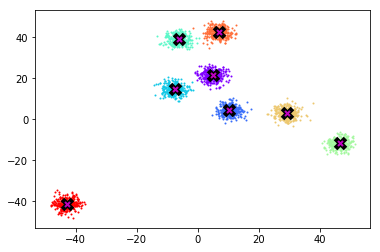

In [9]:
plot_scatters(centroids,sample_datas,num_samples_per_centroid)

In [10]:
def gaussian(x,bw):
    return np.exp(-0.5*x**2/bw**2)/(np.sqrt(2*np.pi)*bw)

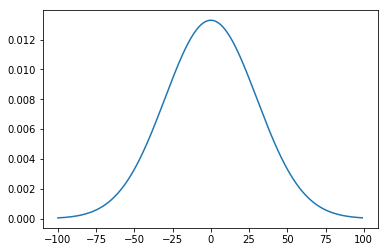

In [11]:
x=np.arange(-100,100)
y=gaussian(x,30)
plt.plot(x,y)

In [12]:
def euclidean_distance(x,data):
    return np.sqrt(((x-data)**2).sum(1))

In [13]:
x=np.array([1,2])
data=np.array([[1,3],[2,3]])
euclidean_distance(x,data)

array([1.        , 1.41421356])

In [14]:
def mean_shift_iter(data,bw=4):
    for i,x in enumerate(data):
        distances=euclidean_distance(x,data)
        weights=gaussian(distances,bw=bw)
        data[i]=(weights[:,None]*data).sum(0)/weights.sum()
    return data

In [15]:
data=sample_datas.copy()

In [16]:
data=mean_shift_iter(data)

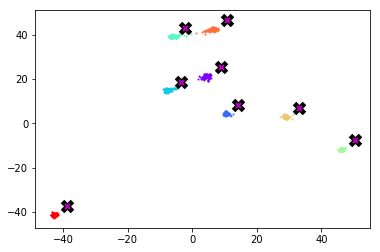

In [17]:
plot_scatters(centroids+4,data,num_samples_per_centroid)

### pytorch implementation

In [18]:
device=torch.device('cuda')

In [25]:
def mean_shift(data):
    data=torch.from_numpy(data)
    data.to(device)
    for i in range(8):
        data=mean_shift_iter(data)
    return data

In [20]:
data=sample_datas.copy()

In [26]:
%time data=mean_shift(data).to('cpu').numpy()

CPU times: user 7.2 s, sys: 991 ms, total: 8.19 s
Wall time: 8.2 s


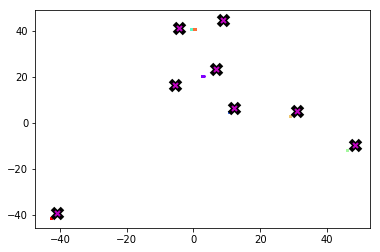

In [27]:
plot_scatters(centroids+2,data,num_samples_per_centroid)

In [28]:
def euclidean_distance_batch(batch_x,data):
    batch_x=batch_x[:,None,:]
    data=data[None,:]
    return np.sqrt(((batch_x-data)**2).sum(2))

In [32]:
# dis=euclidean_distance_batch(sample_datas[:3],sample_datas[:4])
# dis.shape

(3, 4)

In [39]:
def mean_shift_batch(data,batch_size=500):
    data=data.copy()
    data=torch.from_numpy(data)
    data.to(device)
    size=len(data)
    for _ in range(6):
        for i in range(0,size,batch_size):
            high=min(size,i+batch_size)
            slices=slice(i,high)
            distances=euclidean_distance_batch(data[slices],data)
            weights=gaussian(distances)
#             print(weights.shape)
#             print(data.shape)
            batch_points=(weights[:,:,None]*data[None,:,:]).sum(1)
#             print(batch_points.shape)
            data[slices]=batch_points/weights.sum(1)[:,None]
    return data

In [40]:
%time data=mean_shift_batch(sample_datas)

CPU times: user 2.93 s, sys: 27.9 ms, total: 2.96 s
Wall time: 1.44 s


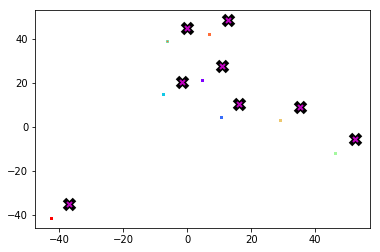

In [42]:
plot_scatters(centroids+6,data,num_samples_per_centroid)